# RNN で sin カーブを予測するサンプル

参考> https://note.com/yiida/n/n421f01614c01


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# sinカーブのデータを作成
x = np.linspace(0, 100, 1000)
y = np.sin(x)

df = pd.DataFrame({"x": x, "y": y})

# CSVとして保存
csv_path = "../data/sin_curve.csv"
df.to_csv(csv_path, index=False)


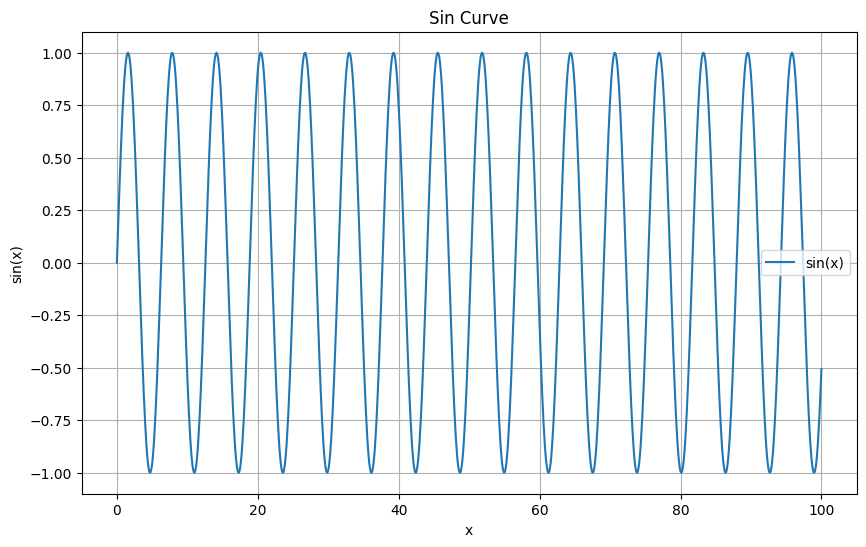

In [3]:
# グラフを描画
plt.figure(figsize=(10, 6))
plt.plot(df["x"], df["y"], label="sin(x)")
plt.title("Sin Curve")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
data = df["y"].values.astype("float32")


# --- Dataset定義 ---
class SinDataset(Dataset):
    def __init__(self, data, look_back=3, horizon=7):
        """
        data: 時系列データ
        look_back: 入力に使うステップ数
        horizon: 何ステップ先を予測するか (例: 7なら T+7 をラベルにする)
        初期値のままなら、X[1,2,3] => y[10] という予測になる
        """
        self.data = data
        self.look_back = look_back
        self.horizon = horizon

    def __len__(self):
        return len(self.data) - self.look_back - self.horizon

    def __getitem__(self, idx):
        X = self.data[idx : idx + self.look_back]
        y = self.data[idx + self.look_back + self.horizon - 1]
        return torch.tensor(X, dtype=torch.float32).unsqueeze(-1), torch.tensor(
            y, dtype=torch.float32
        )


# --- モデル定義 ---
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # 最後のステップの出力のみ使用
        return out


# --- パラメータ ---
look_back = 3  # 何ステップ過去を見るか
horizon = 7  # 何ステップ先を予測するか
batch_size = 32
epochs = 20

# --- Dataset / DataLoader ---
dataset = SinDataset(data, look_back=look_back, horizon=horizon)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- モデル・学習 ---
model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):
    for X_batch, y_batch in dataloader:
        pred = model(X_batch)
        loss = criterion(pred, y_batch.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.6f}")


Epoch 1, Loss: 0.223558
Epoch 2, Loss: 0.040050
Epoch 3, Loss: 0.002734
Epoch 4, Loss: 0.001017
Epoch 5, Loss: 0.000919
Epoch 6, Loss: 0.001549
Epoch 7, Loss: 0.006368
Epoch 8, Loss: 0.001425
Epoch 9, Loss: 0.001058
Epoch 10, Loss: 0.009663
Epoch 11, Loss: 0.001208
Epoch 12, Loss: 0.000468
Epoch 13, Loss: 0.002287
Epoch 14, Loss: 0.000553
Epoch 15, Loss: 0.001540
Epoch 16, Loss: 0.000863
Epoch 17, Loss: 0.003380
Epoch 18, Loss: 0.000443
Epoch 19, Loss: 0.000992
Epoch 20, Loss: 0.000447


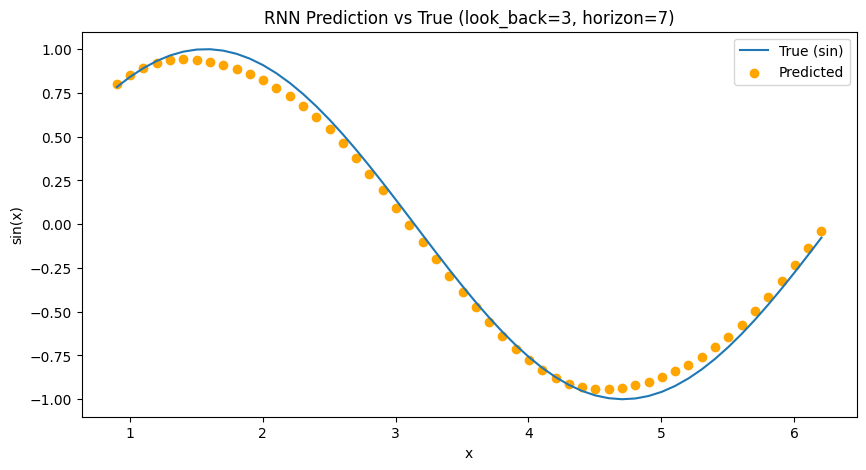

In [5]:
# --- 予測生成 ---
model.eval()
preds = []
targets = []
steps = []

with torch.no_grad():
    for i in range(len(dataset)):
        X, y = dataset[i]  # (look_back, 1), scalar
        X = X.unsqueeze(0)  # (1, look_back, 1)
        pred = model(X).item()
        preds.append(pred)
        targets.append(y.item())
        steps.append(i + look_back + horizon - 1)  # 正解のインデックスに対応

preds = np.array(preds)
targets = np.array(targets)
steps = np.array(steps)

# --- 1周期 (0〜2π) の範囲だけを抽出 ---
x_values = df["x"].values[steps]
mask = x_values <= 2 * np.pi

# --- 可視化 ---
plt.figure(figsize=(10, 5))
plt.plot(x_values[mask], targets[mask], label="True (sin)")
plt.scatter(
    x_values[mask], preds[mask], label="Predicted", color="orange"
)  # ドットのみ表示
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.legend()
plt.title(f"RNN Prediction vs True (look_back={look_back}, horizon={horizon})")
plt.show()
